# 1. Functions

In [1]:
def standardize(parameter):
    """
    :param parameter: the array with the parameters you wish to standardize
    :return param_mean: mean of the input array
    :return param_std : standard deviation of the input array
    :return stdized_param: final standardized array
    """
    import numpy as np
    
    param_mean    = np.mean(parameter)
    param_std     = np.std(parameter)
    stdized_param = []                  # standardized parameter -- output
    for i in range(parameter.size):
        param_temp = (parameter[i] - param_mean)/param_std
        stdized_param.append(param_temp)
    stdized_param = np.array(stdized_param)
    return (param_mean, param_std, stdized_param)

In [2]:
def un_standardize(stdized_par, mean, std):
    """
    This function undoes what the former does!
    """
    
    import numpy as np
    
    recovered_par = []
    for i in range(stdized_par.size):
        param_temp = stdized_par[i]*std + mean
        recovered_par.append(param_temp)
    recovered_par = np.array(recovered_par)
    return (recovered_par)

In [3]:
def print_time(begin_time, end_time):
    """ 
    This function prints the time in minutes that a certain task took.
    """
    print ("--------------------------------------------------")
    print ("CPU process time: %.2f [min]" % float((end-start)/60))
    print ("--------------------------------------------------")

# 2. Packages

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import arviz
import pystan
import time

In [5]:
my_data = pd.read_csv('../../Catalogue/binom_reg_dataset.csv')

In [6]:
# filtering the dataset
redshifts = my_data['Z']
index     = np.where(redshifts.values<=0.4)

# # parameters of interest
logit_class = my_data['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].values[index].astype(int)    # y axis: logit class: UVUP yes/no
whan_class  = my_data['WHAN(0-NA;1-RP;2-wA;3-sA;4-SF)'].values[index].astype(int)  # My types of galaxies
mass        = my_data['STELLAR_MASS'].values[index].astype(float)                  # 1st parameter
redshift    = redshifts.values[index].astype(float)                                # 2nd parameter

In [7]:
# original parameters
mean_mass, std_mass, x2 = standardize(mass)
x1      = redshift
y       = logit_class
classes = (whan_class+1).astype(int)        # Must sum +1 to avoid index issues with STAN
n_obs   = x1.size
n_class = np.unique(classes).size

# new parameters - important for plotting!
n_obs2 = 30
x1_sim = np.linspace(x1.min(), x1.max(), n_obs2)
x2_sim = np.linspace(x2.min(), x2.max(), n_obs2)

# grid
plot_x1, plot_x2 = np.meshgrid(x1_sim, x2_sim)  # THIS IS WHERE THE GRID IS DONE
plot_x1 = plot_x1.reshape((n_obs2**2), 1)
plot_x2 = plot_x2.reshape((n_obs2**2), 1)

In [8]:
# dataset to be used in the regression
regression_data      = {}                                                 # Dictionary, as stated in the pystan manual
regression_data['Y'] = y
regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2, x2, x2**2)))
regression_data['K'] = regression_data['X'][0,:].size                     # Number of betas -- b0, b1, b2, b3, b4
regression_data['W'] = classes
regression_data['N'] = n_obs
regression_data['C'] = n_class                                       # Number of different classes (partial pooling)

# dataset to be used in the plot -- after meshgrid
regression_data['X2'] = sm.add_constant(np.column_stack((plot_x1, plot_x1**2, plot_x2, plot_x2**2)))
regression_data['N2'] = n_obs2**2

In [9]:
regression_data['X']

array([[ 1.        ,  0.13198   ,  0.01741872, -1.70524698,  2.90786727],
       [ 1.        ,  0.1387    ,  0.01923769,  0.1025686 ,  0.01052032],
       [ 1.        ,  0.17168   ,  0.02947402,  0.31307328,  0.09801488],
       ...,
       [ 1.        ,  0.20231   ,  0.04092934,  1.26636376,  1.60367718],
       [ 1.        ,  0.20539   ,  0.04218505,  0.55180499,  0.30448875],
       [ 1.        ,  0.18752   ,  0.03516375,  0.29910587,  0.08946432]])

/home/mlldantas/anaconda3/envs/py3k6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


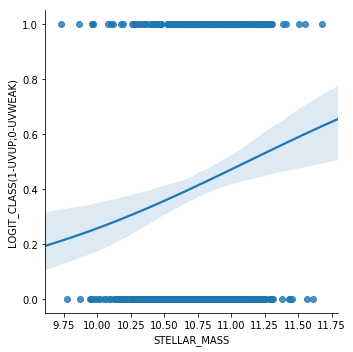

In [10]:
sns.lmplot(x='STELLAR_MASS', y='LOGIT_CLASS(1-UVUP;0-UVWEAK)', data=my_data.iloc[index], logistic=True)
plt.savefig('../../LargeFilesResults/Model/logistic_seaborn.pdf')
plt.show()

### 2.1 Fit: STAN code 

In [11]:
stan_code = """
// DECLARATION OF VARIABLES ------------------------------------------------------------------------------------------
data{
    int<lower=1> N;
    int<lower=1> N2;
    int<lower=1> K;
    int<lower=1> C;
    int W[N];
    int<lower=0, upper=1> Y[N];
    matrix[N, K] X;         // redshift and stellar mass 
    matrix[N2,K] X2;        // redshift and stellar mass -- after grid
    }

// DEFINING THE PRIOR(S) ---------------------------------------------------------------------------------------------
parameters{
    matrix[K,C] beta;         // 25 betas!
//    real<lower=0> sigma;    // Shared hyperpriors
//    real mu;                // Shared hyperpriors
    }

// MODEL: PROBABILITY, HYPERPRIORS, PRIORS, AND REGRESSION -----------------------------------------------------------
model {
   vector[N] prob;
    for (i in 1:N) {
      prob[i] = beta[1,W[i]]*X[i,1] + beta[2,W[i]]*X[i,2] + beta[3,W[i]]*X[i,3] + beta[4,W[i]]*X[i,4] + 
      beta[5,W[i]]*X[i,5];
      }

//    sigma ~ gamma(0.001, 0.001);                           // shared hyperpriors
//    mu ~ normal(0, 100);                                   // shared hyperpriors
     
    for (i in 1:K) {
       for (j in 1:C) beta[i,j] ~ normal(0, 100);       // priors
        }

    Y ~ bernoulli_logit(prob);                             // regression
    }

// DATA TO BE PLOTTED ------------------------------------------------------------------------------------------------
generated quantities{
    vector[N2] prob01;
    vector[N2] eta01;
    vector[N2] prob02;
    vector[N2] eta02;
    vector[N2] prob03;
    vector[N2] eta03;
    vector[N2] prob04;
    vector[N2] eta04;
    vector[N2] prob05;
    vector[N2] eta05;
    
    for(j in 1:N2){
        eta01[j] = beta[1,1]*X2[j,1] + beta[2,1]*X2[j,2] + beta[3,1]*X2[j,3] + beta[4,1]*X2[j,4] + beta[5,1]*X2[j,5];
        eta02[j] = beta[1,2]*X2[j,1] + beta[2,2]*X2[j,2] + beta[3,2]*X2[j,3] + beta[4,2]*X2[j,4] + beta[5,2]*X2[j,5];
        eta03[j] = beta[1,3]*X2[j,1] + beta[2,3]*X2[j,2] + beta[3,3]*X2[j,3] + beta[4,3]*X2[j,4] + beta[5,3]*X2[j,5];
        eta04[j] = beta[1,4]*X2[j,1] + beta[2,4]*X2[j,2] + beta[3,4]*X2[j,3] + beta[4,4]*X2[j,4] + beta[5,4]*X2[j,5];
        eta05[j] = beta[1,5]*X2[j,1] + beta[2,5]*X2[j,2] + beta[3,5]*X2[j,3] + beta[4,5]*X2[j,4] + beta[5,5]*X2[j,5];
        prob01[j] = inv_logit(eta01[j]);
        prob02[j] = inv_logit(eta02[j]);
        prob03[j] = inv_logit(eta03[j]);
        prob04[j] = inv_logit(eta04[j]);
        prob05[j] = inv_logit(eta05[j]);
        }

    }

"""

### 2.2 Fit settings (for STAN)

In [12]:
iterations = 7000
chains     = 3                           # HMC chains
warmup     = 3000                        # How many of the first iterations we'll ignore - burnin
jobs       = -1                          # Run code in parallel -- see pystan documentation
seed       = 1

In [13]:
control = {}
control['max_treedepth'] = 30
control['adapt_delta'] = 0.99

### 2.3 Running the fit

In [14]:
start = time.time()

model = pystan.StanModel(model_code=stan_code)

end = time.time()
print_time(start, end)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5cb83d78da90e6f0b257f8fad4560d83 NOW.


--------------------------------------------------
CPU process time: 1.15 [min]
--------------------------------------------------


In [15]:
start = time.time()

fit = model.sampling(data=regression_data, seed=seed, iter=iterations, chains=chains, warmup=warmup, n_jobs=jobs, 
                     control=control)
end = time.time()
print_time(start, end)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


--------------------------------------------------
CPU process time: 12.41 [min]
--------------------------------------------------


# 3. Retrieving the data from the fit

### 3.1 Saving the entire fit: brace for impact!

In [16]:
start  = time.time()
fit_df = fit.to_dataframe()
end    = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 0.07 [min]
--------------------------------------------------


In [17]:
start = time.time()
fit_df.to_csv('../../LargeFilesResults/Model/entirefit_rmshared_revised.csv', index=False)
end   = time.time()
print_time(start, end)

--------------------------------------------------
CPU process time: 4.11 [min]
--------------------------------------------------


In [18]:
posteriors = fit_df[fit.flatnames[:25]]
header_posteriors = fit.flatnames[:25]

In [19]:
manual_list = [fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]'],  
               fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]'],
               fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]'],
               fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]'],
               fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']]

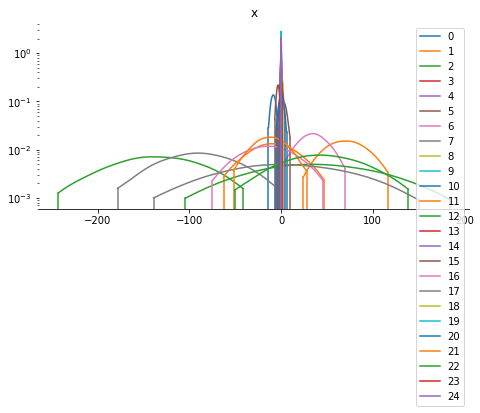

In [22]:
arviz.plot_density(data=manual_list)
plt.yscale('log')
plt.show()

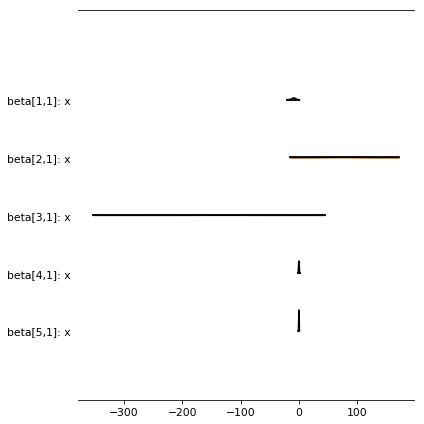

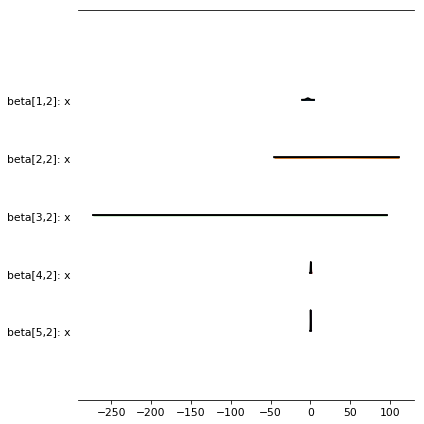

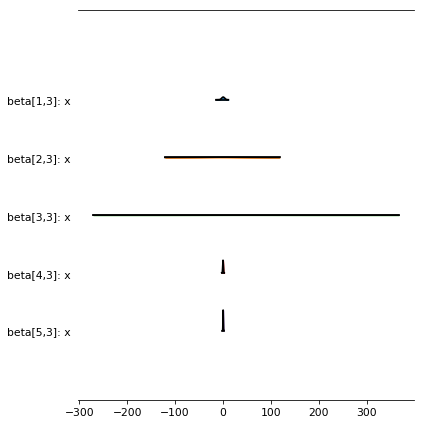

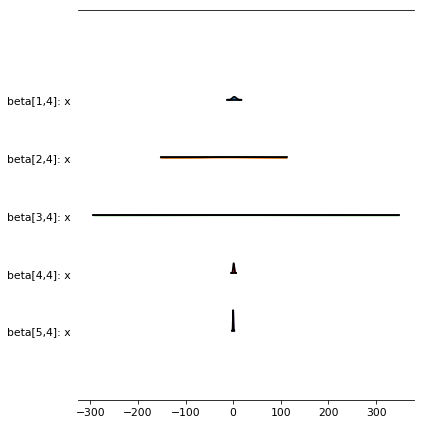

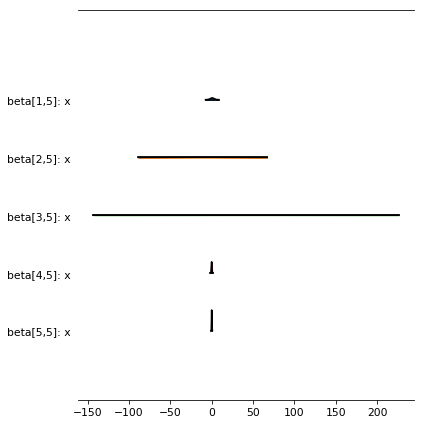

In [23]:
arviz.plot_forest(data=[fit['beta[1,1]'], fit['beta[2,1]'], fit['beta[3,1]'], fit['beta[4,1]'], fit['beta[5,1]']], 
                  kind='ridgeplot', model_names=['beta[1,1]', 'beta[2,1]', 'beta[3,1]', 'beta[4,1]', 'beta[5,1]'],
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest01.png', dpi=150, bbox_inches='tight')

arviz.plot_forest(data=[fit['beta[1,2]'], fit['beta[2,2]'], fit['beta[3,2]'], fit['beta[4,2]'], fit['beta[5,2]']], 
                  kind='ridgeplot', model_names=['beta[1,2]', 'beta[2,2]', 'beta[3,2]', 'beta[4,2]', 'beta[5,2]'], 
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest02.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,3]'], fit['beta[2,3]'], fit['beta[3,3]'], fit['beta[4,3]'], fit['beta[5,3]']], 
                  kind='ridgeplot', model_names=['beta[1,3]', 'beta[2,3]', 'beta[3,3]', 'beta[4,3]', 'beta[5,3]'], 
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest03.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,4]'], fit['beta[2,4]'], fit['beta[3,4]'], fit['beta[4,4]'], fit['beta[5,4]']], 
                  kind='ridgeplot', model_names=['beta[1,4]', 'beta[2,4]', 'beta[3,4]', 'beta[4,4]', 'beta[5,4]'],  
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest04.png', dpi=150, bbox_inches='tight')
plt.show()

arviz.plot_forest(data=[fit['beta[1,5]'], fit['beta[2,5]'], fit['beta[3,5]'], fit['beta[4,5]'], fit['beta[5,5]']], 
                  kind='ridgeplot', model_names=['beta[1,5]', 'beta[2,5]', 'beta[3,5]', 'beta[4,5]', 'beta[5,5]'],  
                  r_hat=False, n_eff=False, figsize=(6,6))
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/betas_forest05.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
figsize=(6,3)

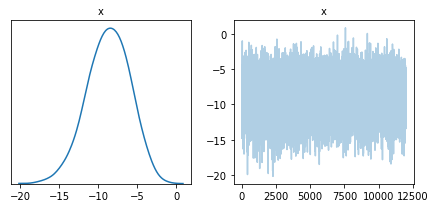

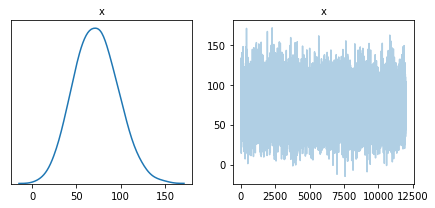

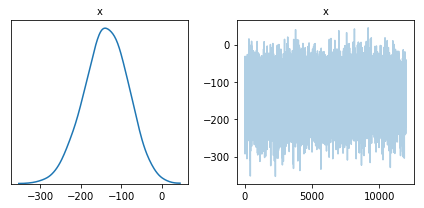

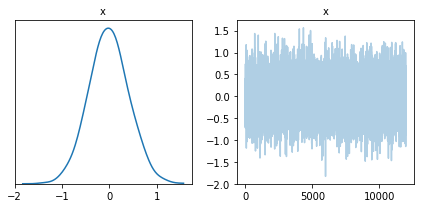

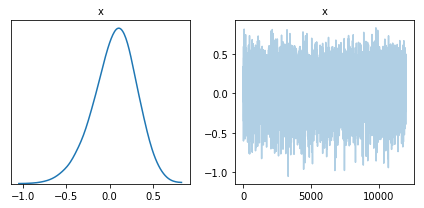

In [25]:
plot = arviz.plot_trace(data=fit['beta[1,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,1]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,1]'], figsize=figsize)
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/trace_class01.pdf', bbox_inches='tight')
plt.show()

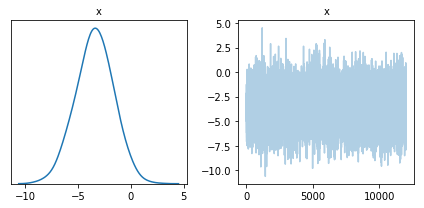

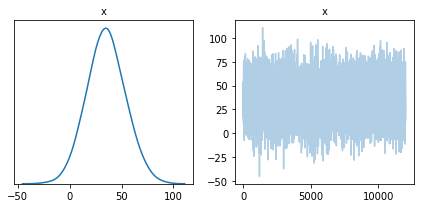

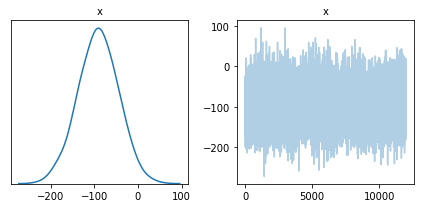

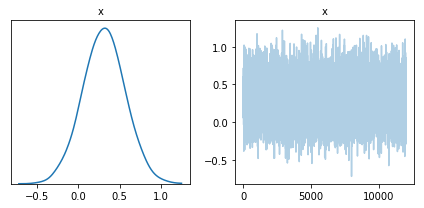

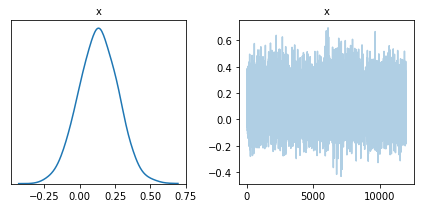

In [26]:
plot = arviz.plot_trace(data=fit['beta[1,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,2]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,2]'], figsize=figsize)
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/trace_class02.pdf', bbox_inches='tight')
plt.show()

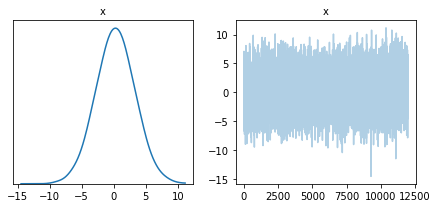

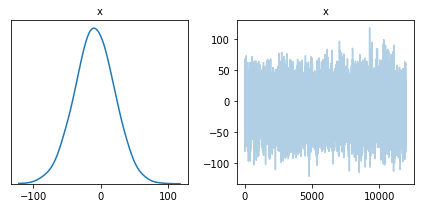

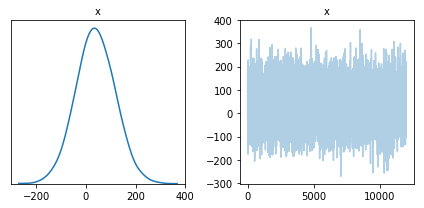

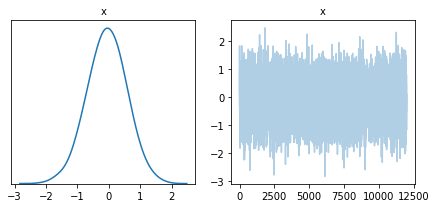

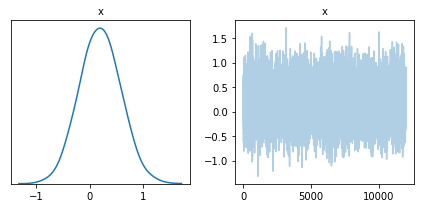

In [27]:
plot = arviz.plot_trace(data=fit['beta[1,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,3]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,3]'], figsize=figsize)
plt.tight_layout()
plt.savefig('../../LargeFilesResults/Model/trace_class03.pdf', bbox_inches='tight')
plt.show()

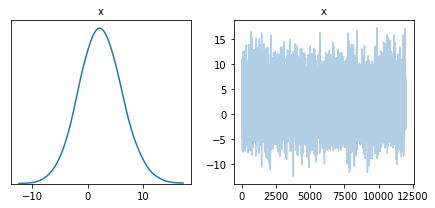

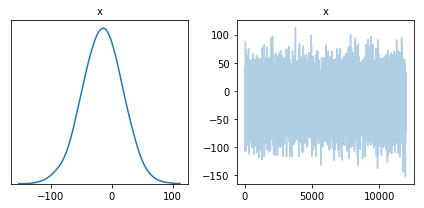

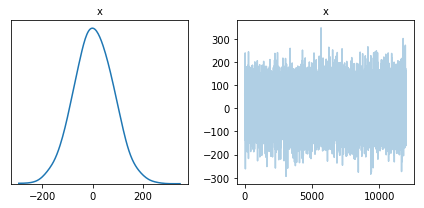

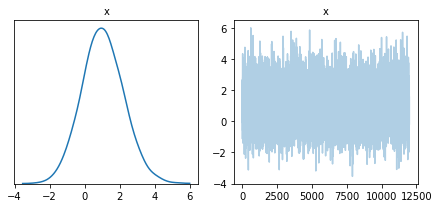

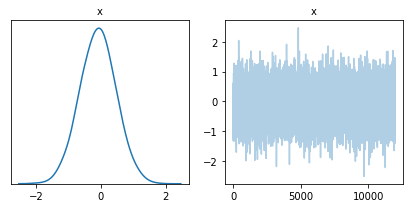

In [28]:
plot = arviz.plot_trace(data=fit['beta[1,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,4]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,4]'], figsize=figsize)
plt.savefig('../../LargeFilesResults/Model/trace_class04.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

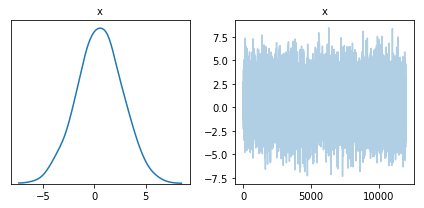

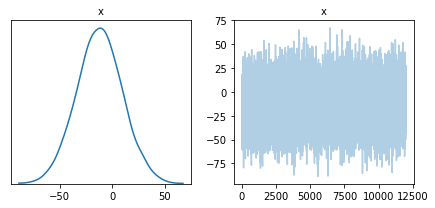

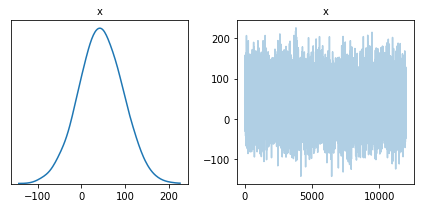

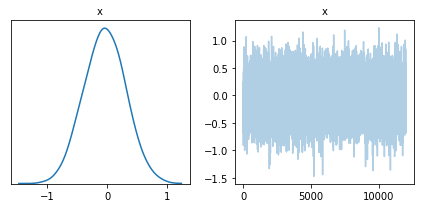

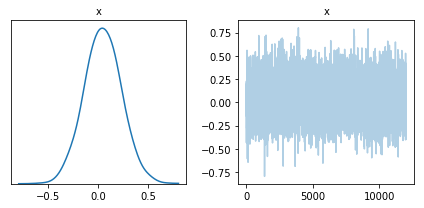

In [29]:
plot = arviz.plot_trace(data=fit['beta[1,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[2,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[3,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[4,5]'], figsize=figsize)
plot = arviz.plot_trace(data=fit['beta[5,5]'], figsize=figsize)
plt.savefig('../../LargeFilesResults/Model/trace_class05.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

### 3.2 Saving the automatic summary from STAN

In [30]:
summary = pystan.stansummary(fit=fit, digits_summary=2)

In [31]:
summary_arr  = np.array(summary.split('\n'))
summary_clean = summary_arr[5:-6,]

In [32]:
header_fit = ['parameter'] + summary_arr[4].split()

#### 3.2.1 Recovering the mass (undo the stadardization) and adding x1 and x2 to the summary

In [33]:
recovered_mass  = un_standardize(stdized_par=plot_x2, mean=mean_mass, std=std_mass)
recovered_pars  = np.column_stack((np.squeeze(plot_x1), np.squeeze(recovered_mass)))
rp      = recovered_pars
rp_cols = np.vstack((rp, rp, rp, rp, rp))    # for 5 whan classes we must stack these 5x

In [1]:
recovered_mass

NameError: name 'recovered_mass' is not defined

In [34]:
recovered_pars

array([[ 0.06794   ,  9.729482  ],
       [ 0.07760759,  9.729482  ],
       [ 0.08727517,  9.729482  ],
       ...,
       [ 0.32896483, 11.67857   ],
       [ 0.33863241, 11.67857   ],
       [ 0.3483    , 11.67857   ]])

In [35]:
rp_cols

array([[ 0.06794   ,  9.729482  ],
       [ 0.07760759,  9.729482  ],
       [ 0.08727517,  9.729482  ],
       ...,
       [ 0.32896483, 11.67857   ],
       [ 0.33863241, 11.67857   ],
       [ 0.3483    , 11.67857   ]])

#### 3.2.2 Checking if the numbers aren't overlaped

In [67]:
new_summary = list(np.zeros(len(header_fit)))
for i in range(summary_clean.size):
    if len(summary_clean[i].split())!=11:
#         print (len(summary_clean[i].split()))
        new_summ_temp = np.array(summary_clean[i].split())
        new_summ_temp = np.concatenate((new_summ_temp, ['X']))
        new_summary   = np.vstack((new_summary, new_summ_temp))
        print ('new_summary[%d] = ' %i, "'%s'" % summary_clean[i])
    else:
        new_summ_temp = np.array(summary_clean[i].split()).reshape(1,11)
        new_summary   = np.vstack((new_summary, new_summ_temp))
new_summary = new_summary[1:,:]            # removing the zeroes in the beggining (line one)
print (new_summary[:,0].shape)

new_summary[5] =  'beta[1,2]    -3.46    0.02   1.79  -6.99  -4.62  -3.43  -2.26-7.0e-3   7663    1.0'
new_summary[88] =  'prob01[64]    0.14  1.3e-3   0.1510.0e-4   0.02   0.08    0.2   0.55  12962    1.0'
new_summary[1175] =  'eta01[251]   -0.59  9.3e-3   0.85  -2.41  -1.12  -0.54-8.5e-3   0.94   8385    1.0'
new_summary[1238] =  'eta01[314]   -0.02  7.8e-3   0.72  -1.47  -0.49-3.4e-3   0.47   1.36   8448    1.0'
new_summary[1336] =  'eta01[412]    0.47  6.4e-3   0.72  -0.93-7.8e-3   0.47   0.95    1.9  12507    1.0'
new_summary[1391] =  'eta01[467]     0.3  4.2e-3   0.45  -0.58-1.2e-3   0.31   0.61    1.2  11831    1.0'
new_summary[1445] =  'eta01[521]   -0.73  3.7e-3   0.38  -1.51  -0.98  -0.73  -0.48-1.7e-3  10514    1.0'
new_summary[1581] =  'eta01[657] -6.5e-3  6.4e-3   0.69  -1.37  -0.45-2.4e-3   0.44   1.34  11576    1.0'
new_summary[1628] =  'eta01[704] -6.1e-3  4.6e-3    0.6  -1.21   -0.4-8.1e-4    0.4   1.15  17024    1.0'
new_summary[1727] =  'eta01[803]     0.6  7.6e-3   

In [68]:
# new_summary[5] =  'beta[1,2]    -3.46    0.02   1.79  -6.99  -4.62  -3.43  -2.26 -7.0e-3   7663    1.0'
# new_summary[88] =  'prob01[64]    0.14  1.3e-3   0.15 10.0e-4   0.02   0.08    0.2   0.55  12962    1.0'
# new_summary[1175] =  'eta01[251]   -0.59  9.3e-3   0.85  -2.41  -1.12  -0.54 -8.5e-3   0.94   8385    1.0'
# new_summary[1238] =  'eta01[314]   -0.02  7.8e-3   0.72  -1.47  -0.49 -3.4e-3   0.47   1.36   8448    1.0'
# new_summary[1336] =  'eta01[412]    0.47  6.4e-3   0.72  -0.93 -7.8e-3   0.47   0.95    1.9  12507    1.0'
# new_summary[1391] =  'eta01[467]     0.3  4.2e-3   0.45  -0.58 -1.2e-3   0.31   0.61    1.2  11831    1.0'
# new_summary[1445] =  'eta01[521]   -0.73  3.7e-3   0.38  -1.51  -0.98  -0.73  -0.48 -1.7e-3  10514    1.0'
# new_summary[1581] =  'eta01[657] -6.5e-3  6.4e-3   0.69  -1.37  -0.45 -2.4e-3   0.44   1.34  11576    1.0'
# new_summary[1628] =  'eta01[704] -6.1e-3  4.6e-3    0.6  -1.21   -0.4 -8.1e-4    0.4   1.15  17024    1.0'
# new_summary[1727] =  'eta01[803]     0.6  7.6e-3   0.91  -1.21 -6.9e-3    0.6   1.21   2.36  14351    1.0'
# new_summary[1773] =  'eta01[849]    -1.0    0.01   1.49  -4.05  -1.97  -0.98 -1.9e-3   1.86  17529    1.0'
# new_summary[2424] =  'prob02[600]   0.15  1.5e-3   0.14 10.0e-3   0.05    0.1    0.2   0.55   9069    1.0'
# new_summary[2807] =  'eta02[83]    -0.86    0.01   1.29  -3.47   -1.7  -0.84 -2.6e-3   1.65  12808    1.0'
# new_summary[2836] =  'eta02[112]   -0.77    0.01   1.16  -3.12  -1.54  -0.76 -4.2e-3   1.51  12513    1.0'
# new_summary[2865] =  'eta02[141]   -0.69  9.5e-3   1.04  -2.79  -1.38  -0.68 -2.7e-3   1.35  12224    1.0'
# new_summary[2914] =  'eta02[190]   -0.41  6.2e-3   0.62  -1.66  -0.81   -0.4 -5.3e-4   0.78   9988    1.0'
# new_summary[2952] =  'eta02[228]    -0.5  6.8e-3   0.73  -1.95  -0.98   -0.5 -8.8e-3   0.95  11448    1.0'
# new_summary[3033] =  'eta02[309]   -0.53  2.6e-3   0.27  -1.08  -0.71  -0.52  -0.35 -9.5e-3  11091    1.0'
# new_summary[3124] =  'eta02[400]   -0.39  1.8e-3    0.2  -0.78  -0.52  -0.39  -0.26 -5.3e-3  12032    1.0'
# new_summary[3143] =  'eta02[419]   -2.33    0.01   1.19   -4.7  -3.13  -2.33  -1.52 -4.8e-3  11888    1.0'
# new_summary[3174] =  'eta02[450]   -2.56    0.01   1.31  -5.16  -3.44  -2.57  -1.67 -6.9e-3  11131    1.0'
# new_summary[3182] =  'eta02[458]   -0.45  2.2e-3   0.23  -0.91  -0.61  -0.45   -0.3 -9.0e-3  11095    1.0'
# new_summary[3434] =  'eta02[710]    0.23  2.9e-3   0.34  -0.43 -2.8e-4   0.22   0.45   0.91  14243    1.0'
# new_summary[3500] =  'eta02[776]   -0.45  6.1e-3   0.67  -1.77   -0.9  -0.46 -4.2e-3   0.86  12075    1.0'
# new_summary[3773] =  'prob03[149]   0.71  2.9e-3   0.34 10.0e-3   0.47   0.89   0.99    1.0  13508    1.0'
# new_summary[3803] =  'prob03[179]    0.7  2.9e-3   0.34 10.0e-3   0.44   0.88   0.99    1.0  13697    1.0'
# new_summary[4612] =  'eta03[88]     2.41    0.03    3.6  -4.56 -4.8e-4   2.32   4.79   9.64  17041    1.0'
# new_summary[4839] =  'eta03[315]  6.8e-3  9.2e-3    1.0  -1.94  -0.65 -3.5e-3   0.67   1.98  11656    1.0'
# new_summary[4922] =  'eta03[398]   -0.38  4.9e-3   0.56  -1.48  -0.75  -0.38 -4.5e-3    0.7  13146    1.0'
# new_summary[4924] =  'eta03[400]   -0.36  4.7e-3   0.53  -1.41  -0.72  -0.35 -5.6e-3   0.69  12679    1.0'
# new_summary[5048] =  'eta03[524]   -0.32  4.2e-3   0.47  -1.23  -0.63  -0.31 -3.2e-3    0.6  12377    1.0'
# new_summary[5074] =  'eta03[550]   -0.42  5.3e-3   0.61  -1.65  -0.82   -0.4 -6.3e-3   0.76  13398    1.0'
# new_summary[5083] =  'eta03[559]  2.7e-3  6.8e-3   0.78  -1.52  -0.52 -6.2e-3   0.51   1.57  13128    1.0'
# new_summary[5142] =  'eta03[618]  7.2e-3  5.8e-3   0.66  -1.27  -0.42 -1.6e-3   0.44   1.34  12691    1.0'
# new_summary[5171] =  'eta03[647]  7.5e-4  6.6e-3   0.73  -1.43  -0.49 -6.9e-3   0.49   1.45  12380    1.0'
# new_summary[5217] =  'eta03[693]   -0.05    0.02   2.04  -4.15  -1.41 -2.1e-3   1.31   3.92  11173    1.0'
# new_summary[5495] =  'prob04[71]    0.12  1.9e-3    0.2 10.0e-5 5.3e-3   0.03   0.14   0.76  11199    1.0'
# new_summary[5956] =  'prob04[532]   0.25  1.9e-3   0.21 10.0e-3   0.08   0.19   0.38   0.76  11901    1.0'
# new_summary[6123] =  'prob04[699]   0.65  3.4e-3   0.35 10.0e-3   0.33   0.79   0.97    1.0  10336    1.0'
# new_summary[6140] =  'prob04[716]   0.33  2.2e-3   0.26 10.0e-3   0.11   0.27   0.53   0.89  13572    1.0'
# new_summary[6510] =  'eta04[186]   -1.71  9.1e-3   0.98  -3.87   -2.3  -1.63  -1.03 -4.3e-3  11564    1.0'
# new_summary[6657] =  'eta04[333]   -0.01    0.01   1.14  -2.26  -0.76 -6.7e-3   0.75   2.22   9512    1.0'
# new_summary[6723] =  'eta04[399]   -0.44  5.5e-3   0.65  -1.74  -0.87  -0.43 -6.6e-3   0.81  13835    1.0'
# new_summary[6908] =  'eta04[584]  3.5e-3  8.9e-3    1.0  -1.97  -0.67 -9.8e-3   0.67   1.98  12673    1.0'
# new_summary[7008] =  'eta04[684]   -0.92    0.01   1.36  -3.79  -1.77  -0.87 -8.1e-3   1.56  13046    1.0'
# new_summary[7042] =  'eta04[718]   -1.32    0.02   1.93   -5.4  -2.53  -1.23 -2.0e-4    2.2  13593    1.0'
# new_summary[7187] =  'eta04[863]   -0.01    0.04   4.36  -8.61   -2.9 -3.3e-3    2.9   8.55  10855    1.0'
# new_summary[8220] =  'eta05[96]  -5.2e-3  9.1e-3   0.99  -1.96  -0.66 -2.7e-3   0.65   1.98  11893    1.0'
# new_summary[8257] =  'eta05[133] -7.5e-3    0.01   1.14  -2.26  -0.75 -8.2e-4   0.74   2.23   8751    1.0'
# new_summary[8328] =  'eta05[204]    0.79    0.01   1.17  -1.54 -6.9e-4   0.79   1.58   3.05  13155    1.0'
# new_summary[8365] =  'eta05[241] -4.3e-3  7.7e-3   0.69  -1.39  -0.47 10.0e-3   0.47   1.33   8217    1.0'
# new_summary[8528] =  'eta05[404]   -0.26  3.6e-3   0.36  -0.97  -0.51  -0.25 -8.3e-3   0.46  10051    1.0'
# new_summary[8597] =  'eta05[473]    0.43  5.3e-3   0.66  -0.87 -9.0e-3   0.43   0.87   1.72  15090    1.0'
# new_summary[8740] =  'eta05[616]    -0.2  2.6e-3   0.28  -0.76  -0.39   -0.2 -4.2e-3   0.35  12137    1.0'
# new_summary[8988] =  'eta05[864]    0.69  8.6e-3   1.04  -1.32 -5.6e-3   0.69   1.38   2.79  14541    1.0'

In [76]:
print (new_summary.shape)

(9025, 11)


#### 3.2.3 Retrieving only the probabilities from the summary and stacking x1 and x2 at the end of the dataframe

In [77]:
parameters = new_summary[:,0].astype(str)
pnew_idxs  = []
for i in range(parameters.size):
    if parameters[i][0:4]=='prob':
        pnew_idxs.append(i)
    else:
        continue
print (new_summary[pnew_idxs,:].shape, rp_cols.shape)
model_results    = np.column_stack((new_summary[pnew_idxs,:], rp_cols))
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = header_fit + ['Z'] + ['LOG_STELLAR_MASS']
model_results_df.index = model_results_df['parameter']
model_results_df = model_results_df.drop(columns='parameter', axis=1)
model_results_df.to_csv('../../LargeFilesResults/Model/fit_summary_rmshared_revised.csv', header=True, index=True)

(4500, 11) (4500, 2)


In [78]:
model_results_df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat,Z,LOG_STELLAR_MASS
parameter,,,,,,,,,,,,
prob01[1],0.07,9.8e-4,0.11,9.1e-5,4.8e-3,0.02,0.09,0.42,13374,1.0,0.06794,9.729482
prob01[2],0.1,1.3e-3,0.15,1.4e-4,7.6e-3,0.04,0.14,0.56,13203,1.0,0.07760758620689655,9.729482
prob01[3],0.15,1.7e-3,0.19,2.1e-4,0.01,0.06,0.2,0.69,12685,1.0,0.0872751724137931,9.729482
prob01[4],0.19,2.1e-3,0.23,3.1e-4,0.02,0.09,0.29,0.8,12040,1.0,0.09694275862068966,9.729482
prob01[5],0.24,2.5e-3,0.26,4.3e-4,0.03,0.13,0.39,0.88,11374,1.0,0.1066103448275862,9.729482
prob01[6],0.29,2.8e-3,0.29,5.5e-4,0.04,0.18,0.5,0.92,10769,1.0,0.11627793103448275,9.729482
prob01[7],0.34,3.1e-3,0.31,7.2e-4,0.05,0.24,0.59,0.95,10202,1.0,0.1259455172413793,9.729482
prob01[8],0.38,3.3e-3,0.33,9.4e-4,0.07,0.31,0.68,0.97,9737,1.0,0.13561310344827587,9.729482
prob01[9],0.43,3.5e-3,0.34,1.2e-3,0.09,0.38,0.75,0.98,9367,1.0,0.1452806896551724,9.729482


In [79]:
posteriors = fit_df[fit.flatnames[:25]]

In [80]:
fit_df.keys()

Index(['chain', 'draw', 'warmup', 'beta[1,1]', 'beta[2,1]', 'beta[3,1]',
       'beta[4,1]', 'beta[5,1]', 'beta[1,2]', 'beta[2,2]',
       ...
       'eta05[898]', 'eta05[899]', 'eta05[900]', 'lp__', 'accept_stat__',
       'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'],
      dtype='object', length=9035)

In [81]:
fit_df['treedepth__'].describe()

count    12000.000000
mean         8.636167
std          0.508737
min          5.000000
25%          8.000000
50%          9.000000
75%          9.000000
max         10.000000
Name: treedepth__, dtype: float64

In [82]:
fit_df['n_leapfrog__'].describe()

count    12000.000000
mean       494.054667
std        179.033394
min         47.000000
25%        511.000000
50%        511.000000
75%        511.000000
max       2047.000000
Name: n_leapfrog__, dtype: float64

In [83]:
posteriors.to_csv('../../LargeFilesResults/Model/posteriors_rmshared_revised.csv', index=False)

In [84]:
posteriors

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[1,2]","beta[2,2]","beta[3,2]","beta[4,2]","beta[5,2]",...,"beta[1,4]","beta[2,4]","beta[3,4]","beta[4,4]","beta[5,4]","beta[1,5]","beta[2,5]","beta[3,5]","beta[4,5]","beta[5,5]"
0,-12.187872,107.652765,-218.487915,-0.068169,-0.014077,-4.562748,43.272291,-100.723852,0.205079,0.117344,...,5.041107,-59.315118,149.961612,-0.223876,-0.945536,-3.669918,27.459816,-46.362887,-0.397376,0.223145
1,-11.399028,96.402363,-194.169729,-0.350926,0.420846,-2.778258,31.618536,-96.240046,0.395766,0.047736,...,0.102390,-2.660499,-2.127995,0.121996,-0.345262,-2.291965,10.805416,5.558238,-0.632260,-0.059929
2,-10.597359,90.666617,-177.108472,-0.214381,-0.110351,-3.479320,30.153927,-70.409865,0.228308,0.102696,...,-3.142631,37.522926,-120.853234,-0.250283,-0.305395,-0.600042,-1.745767,15.866603,0.031647,0.151940
3,-8.879341,75.106981,-150.363251,0.065239,-0.060980,-1.344217,14.005408,-46.534047,0.358632,0.072889,...,6.298590,-54.760554,95.200227,0.071514,-0.694375,-1.934135,15.978438,-45.563740,0.284740,0.394396
4,-9.004124,73.956605,-148.065263,0.083866,0.220893,-3.148192,33.315412,-92.163772,0.283440,0.066849,...,7.558020,-68.390533,113.705120,2.510280,0.232269,-1.472172,5.751046,12.362552,-0.486874,0.032497
5,-11.278493,95.537927,-193.264592,-0.085815,0.205122,-5.548649,48.894333,-103.200318,-0.323149,0.262688,...,8.592924,-72.272151,95.670491,3.388541,0.591769,-3.878703,25.179626,-28.077448,-0.837301,0.080280
6,-8.122827,73.821860,-165.240832,0.065068,0.338746,-5.088281,48.973787,-124.412209,0.308369,0.211113,...,5.259527,-26.346877,-60.235113,3.863860,0.680505,-0.922656,3.631337,11.746272,-0.292026,-0.186669
7,-11.116616,89.858548,-167.817978,-0.397634,0.002647,-3.606579,38.284378,-104.968243,0.381461,0.241698,...,8.289012,-51.527129,-26.325592,3.877568,1.018447,0.458917,-15.203308,64.183541,-0.306121,-0.013604
8,-9.995740,78.765510,-145.157701,-0.278246,0.259866,-4.986891,55.656778,-149.895163,0.362309,-0.118846,...,9.786922,-47.614572,-74.150935,5.112579,1.364821,2.490556,-27.547631,66.808999,0.409728,0.036043
9,-9.344343,75.739879,-152.178132,0.234031,0.131032,-4.730022,40.796317,-89.161150,-0.001119,0.205941,...,4.372643,-37.388934,27.180198,1.999781,0.426274,0.709881,-15.646854,58.353285,-0.233383,-0.091742


In [85]:
diagnostics = pystan.check_hmc_diagnostics(fit, per_chain=True)

In [86]:
diagnostics

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [87]:
pystan.check_hmc_diagnostics??

In [88]:
model_results_df['Rhat'].max()

'prob04[71]    0.12  1.9e-3    0.'

In [89]:
model_results_df['Rhat'].min()

'1.0'